# Uber Data Analytics 

## Objectives
- Take a dataset of Uber and build a data model.
- Data Transformation in Python and deploy the code on GCP cloud instance.
- Build a pipeline using MAGE.
- Load the data on BigQuery and perform Data Analytics.
- Create a dashboard on Looker Studio.

## Dataset
The dataset used for this project is taken from Uber trip records of NYC's Taxi and Limousine Commission (TLC) that can be accessed using this [Link](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). <br />

A subset of the data consisting 100k trips is used for this project - [Dataset](https://www.kaggle.com/datasets/praveenluppunda/uber-dataset)

Data Dictionary for Yellow Taxi Trip data - https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

## Tech Stack
### Languages Used

- Python
- SQL

### Tools Used

- Google Cloud Storage
- Compute Instance
- MAGE
- Google BigQuery
- Looker Studio

# Approach
## 1. Data Acquisition
The dataset is taken from Uber trip records of NYC's Taxi and Limousine Commission (TLC). Only a subset of the data consisting 100k trips is used for analysis. This CSV file is stored on Google Cloud Storage Bucket and is fetched using MAGE Data Loader block for subsequent steps in the ETL pipeline.

## 2. Data Modeling
The flat file obtained as data set will be converted to Fact Table and Dimension Table.

### Fact Table
- Has quantitative measures used for analysis.
- Contains references to Dimension table.
- Has columns with high cardinality and changes frequently.
- Contains columns which are not useful for analysis by themselves but are necessary for calculating metrics.

### Dimension Table
- Contains columns which describe attributes of data being analyzed.
- Has Primary Keys that links fact table.
- Has columns with low cardinality and doesn't change frequently.
- Contains columns which are used for grouping or filtering data for analysis.

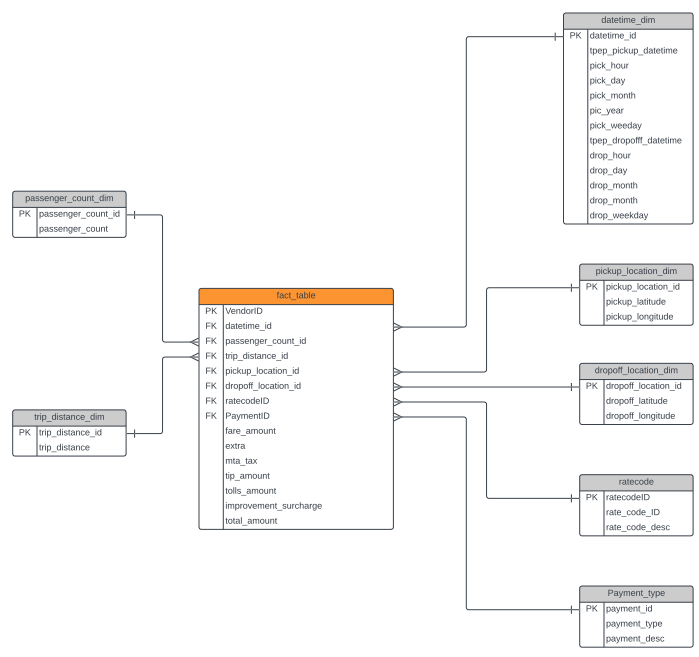

### 3. Data Transformation
Transformation of the loaded data as per our requirement is done using MAGE Transformation block.
Some of the transformation done include:

- Data Cleaning
- Dropping duplicates and resetting indexes.
- Converting the columns storing date values/timestamp in the DataFrame to datetime type.
- Developing Dimension Tables and Fact Table. Once all the dimension tables are created, to create a fact table we merge the main dataframe on all of the dimension tables based on the common key present between them.

### 4. BigQuery Analytics
The Dimension tables and fact table created in Transformation block is uploaded on to BigQuery. Google BigQuery is a fully-managed data warehouse that provides efficient data storage, retrieval, and querying capabilities, and valuable insights from the data.
An Analytical table is created which is more like a master table, that is used for analytics.

### 5. Dashboard Development on Looker Studio
An interactive dashboard is developed using Looker which helps in visualizing the results and deriving insights. Link to the Dashboards:
- [Dashboard 1](https://lookerstudio.google.com/s/i-snpqVJXv4)
- [Dashboard 2](https://lookerstudio.google.com/s/uAsTFkh8PnE)

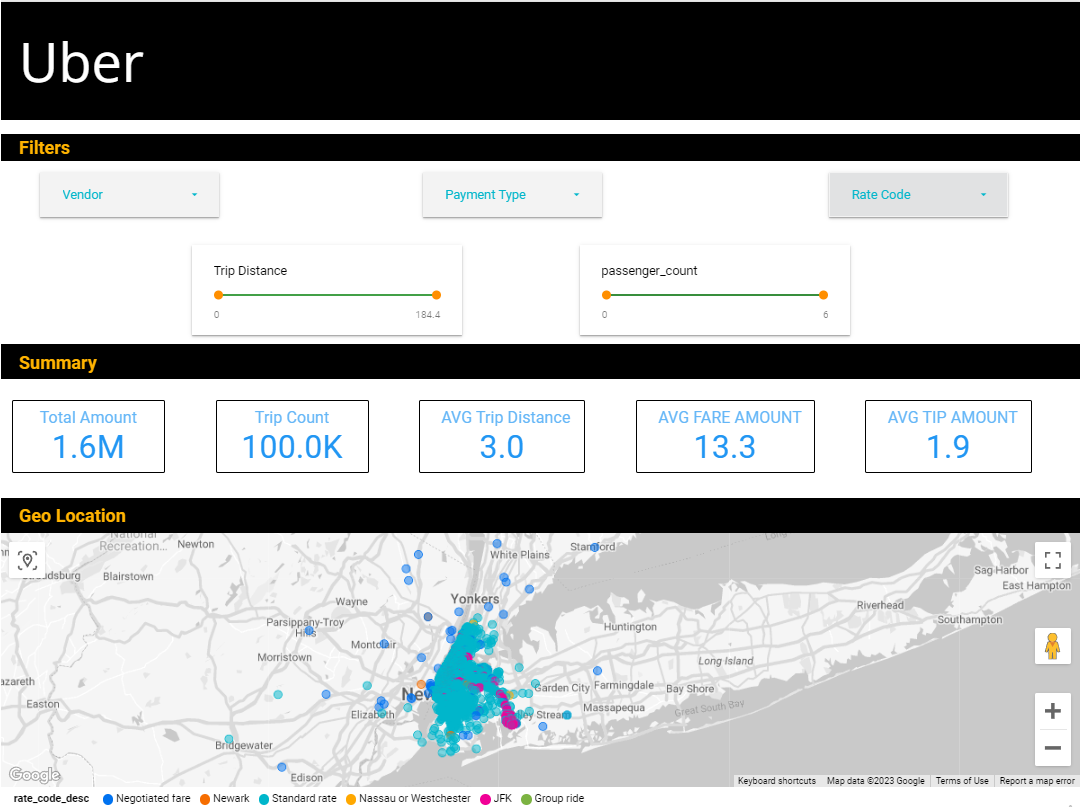

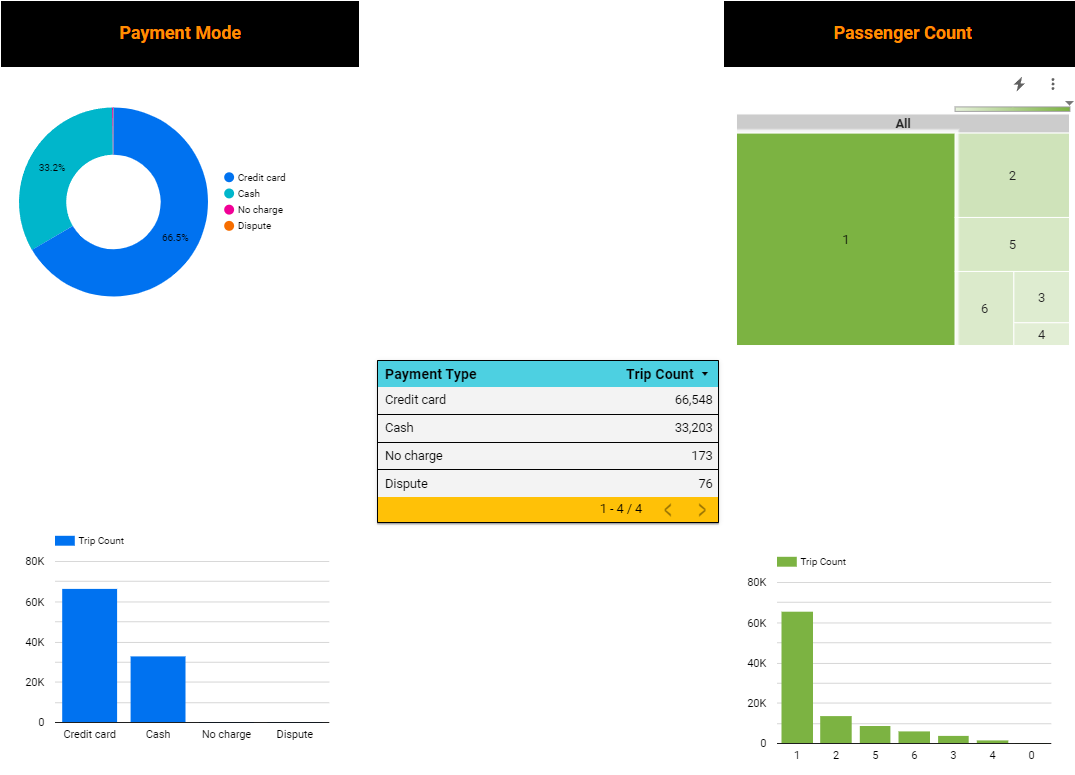

# Code

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/kaggle/input/uber-dataset/uber_data.csv")
df.head(10)

In [ ]:
df.info()

#### Converting pickup and dropoff columns type to datetime

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df.info()

#### Dropping duplicates and resetting the index

In [ ]:
df = df.drop_duplicates().reset_index(drop = True)
df['trip_id'] = df.index
df

#### Dimension table for datetime columns and computing other datetime values

In [ ]:
datetime_dim = df[['tpep_pickup_datetime','tpep_dropoff_datetime']].drop_duplicates().reset_index(drop = True)

# Pickup Time
datetime_dim['pick_hour'] = datetime_dim['tpep_pickup_datetime'].dt.hour
datetime_dim['pick_day'] = datetime_dim['tpep_pickup_datetime'].dt.day
datetime_dim['pick_month'] = datetime_dim['tpep_pickup_datetime'].dt.month
datetime_dim['pick_year'] = datetime_dim['tpep_pickup_datetime'].dt.year
datetime_dim['pick_weekday'] = datetime_dim['tpep_pickup_datetime'].dt.weekday


# Dropoff Time
datetime_dim['drop_hour'] = datetime_dim['tpep_dropoff_datetime'].dt.hour
datetime_dim['drop_day'] = datetime_dim['tpep_dropoff_datetime'].dt.day
datetime_dim['drop_month'] = datetime_dim['tpep_dropoff_datetime'].dt.month
datetime_dim['drop_year'] = datetime_dim['tpep_dropoff_datetime'].dt.year
datetime_dim['drop_weekday'] = datetime_dim['tpep_dropoff_datetime'].dt.weekday
datetime_dim

In [ ]:
datetime_dim['datetime_id'] = datetime_dim.index
datetime_dim = datetime_dim[['datetime_id','tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pick_hour',
       'pick_day', 'pick_month', 'pick_year', 'pick_weekday', 'drop_hour',
       'drop_day', 'drop_month', 'drop_year', 'drop_weekday']]
datetime_dim

#### Dimension table of passenger count

In [ ]:
passenger_count_dim = df[['passenger_count']].drop_duplicates().reset_index(drop = True)
passenger_count_dim['passenger_count_id'] = passenger_count_dim.index
passenger_count_dim = passenger_count_dim[['passenger_count_id','passenger_count']]
passenger_count_dim

#### Dimension table of Trip distance

In [ ]:
trip_distance_dim = df[['trip_distance']].drop_duplicates().reset_index(drop = True)
trip_distance_dim['trip_distance_id'] = trip_distance_dim.index
trip_distance_dim = trip_distance_dim[['trip_distance_id','trip_distance']]
trip_distance_dim

#### Dimension table of Payment Type

Payment Type is a categorical variable. Hence, we use map method to assign a value/description to each code.

In [ ]:
payment_mode_type = {
    1:"Credit card",
    2:"Cash",
    3:"No charge",
    4:"Dispute",
    5:"Unknown",
    6:"Voided trip"
}

payment_type_dim = df[['payment_type']].drop_duplicates().reset_index(drop = True)
payment_type_dim['payment_type_id'] = payment_type_dim.index
payment_type_dim['payment_type_desc'] = payment_type_dim['payment_type'].map(payment_mode_type)
payment_type_dim = payment_type_dim[['payment_type_id','payment_type','payment_type_desc']]
payment_type_dim

#### Dimension table of Rate Code

Rate Code is a categorical variable. Hence, we use map method to assign a value/description to each code.

In [ ]:
rate_code_type = {
    1:"Standard rate",
    2:"JFK",
    3:"Newark",
    4:"Nassau or Westchester",
    5:"Negotiated fare",
    6:"Group ride"
}

rate_code_dim = df[['RatecodeID']].drop_duplicates().reset_index(drop = True)
rate_code_dim['rate_code_id'] = rate_code_dim.index
rate_code_dim['rate_code_desc'] = rate_code_dim['RatecodeID'].map(rate_code_type)
rate_code_dim = rate_code_dim[['rate_code_id','RatecodeID','rate_code_desc']]
rate_code_dim

#### Dimension table of Dropoff Location

In [ ]:
dropoff_location_dim = df[['dropoff_latitude','dropoff_longitude']].drop_duplicates().reset_index(drop = True)
dropoff_location_dim['dropoff_loc_id'] = dropoff_location_dim.index
dropoff_location_dim = dropoff_location_dim[['dropoff_loc_id','dropoff_latitude','dropoff_longitude']]
dropoff_location_dim

#### Dimension table of Pickup Location

In [ ]:
pickup_location_dim = df[['pickup_latitude','pickup_longitude']].drop_duplicates().reset_index(drop = True)
pickup_location_dim['pickup_loc_id'] = pickup_location_dim.index
pickup_location_dim = pickup_location_dim[['pickup_loc_id','pickup_latitude','pickup_longitude']]
pickup_location_dim

***Once all the dimension tables are created, to create a fact table we merge the main dataframe on all of the dimension tables based on the common key present between them.***

In [ ]:
fact_table = df.merge(passenger_count_dim, on = 'passenger_count') \
             .merge(trip_distance_dim, on = 'trip_distance') \
             .merge(rate_code_dim , on = 'RatecodeID') \
             .merge(pickup_location_dim, on = ['pickup_longitude','pickup_latitude']) \
             .merge(dropoff_location_dim, on = ['dropoff_longitude', 'dropoff_latitude']) \
             .merge(datetime_dim, on = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']) \
             .merge(payment_type_dim, on = ['payment_type']) \
             [['trip_id','VendorID','datetime_id','passenger_count_id','trip_distance_id','rate_code_id','store_and_fwd_flag','pickup_loc_id','dropoff_loc_id','payment_type_id','fare_amount','extra', 'mta_tax', 'tip_amount', 'tolls_amount','improvement_surcharge','total_amount']]

In [ ]:
fact_table